# CatBoosted EfficientNet approach for Pawpularity prediction

Even though, the most performing solution that are publicly available in this competition uses Swin Transformer models and RAPIDS SVR boost models. There are many other "simpler" solution that achieved good results such as the CatBoost- EffNet B2 by [ROBIN SMITS](https://www.kaggle.com/rsmits/effnet-b2-feature-models-catboost), and the Pretrained EfficientNet by [DEV KHANT](http://https://www.kaggle.com/devkhant24/pretrained-model-efficientnet).

In this notebook, I present a CatBoosted EfficientNet model which is a quite simple structured model and it achieves acceptable results.
The model architeture used in this notebook is presented in the following graph:

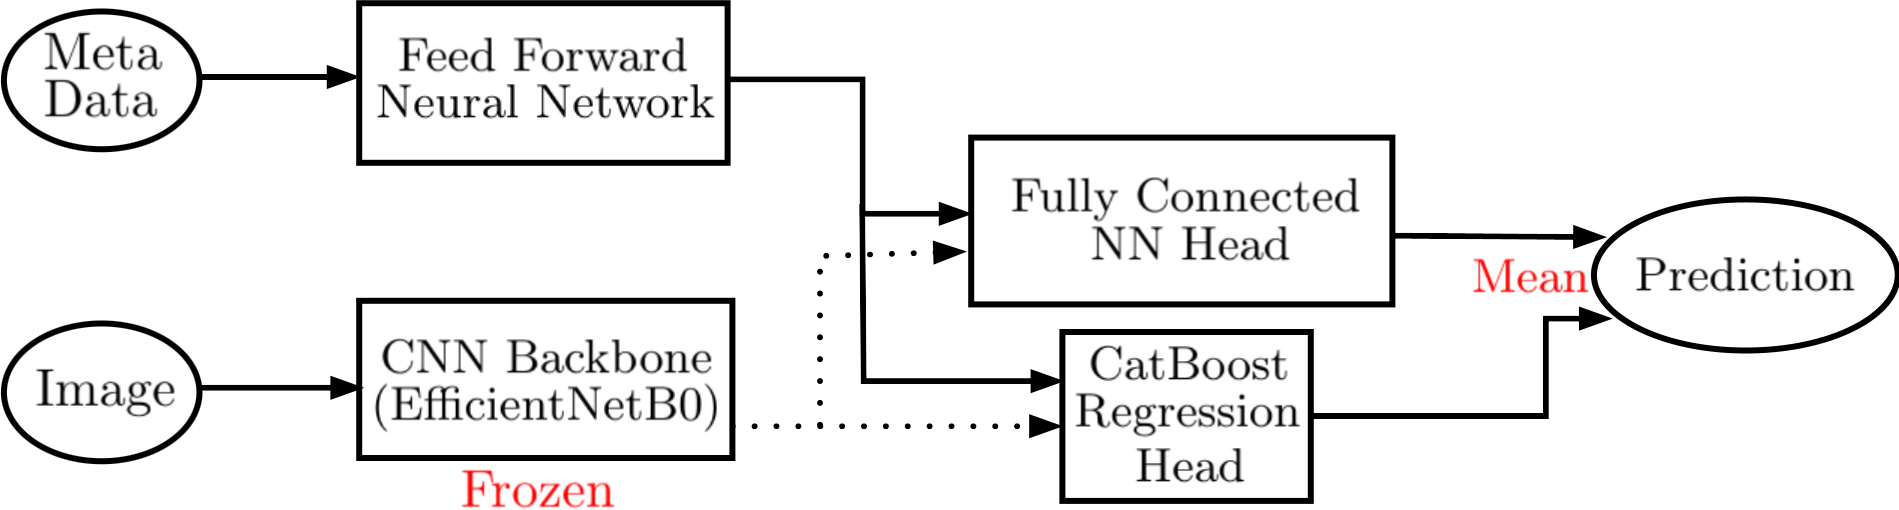

The pocess of training this model is conducted over two steps:
1. Training a model with a frozen EfficientNetB0 backbone for image feature extraction, a shallow dense network for the meta data input, and a fully connected head.
2. Using the trained model in the first step, and replacing the head with a catboost regression model.

The final predication is calculated as the average prediction of both models.


In [ ]:
# Importing libraries
import os
import random
import gc
import warnings

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import catboost as cb

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, concatenate, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

In [ ]:
# Importing the training data
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df.head()

In [ ]:
# Importing the test data
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_id = test_df.Id.copy()
test_df.head()

In [ ]:
# Setting seeds
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

# Setting constants
batch_size = 32
image_size = 224
channels = 3
shuffle_size = 1024 

# Setting auto tune
AUTOTUNE = tf.data.experimental.AUTOTUNE  

In [ ]:
# Splittin the training data into training and validation sets
# Train_df, Val_df = train_test_split(train_df, test_size=0.09, random_state=123)
Train_df = train_df.iloc[:9000,:]
Val_df = train_df.iloc[9000:,:]

In [ ]:
# Mapping the images ID to the image paths
Train_df.Id = Train_df.Id.map(lambda x: '../input/petfinder-pawpularity-score/train/' + x + '.jpg')
Val_df.Id = Val_df.Id.map(lambda x: '../input/petfinder-pawpularity-score/train/' + x + '.jpg')
test_df.Id = test_df.Id.map(lambda x: '../input/petfinder-pawpularity-score/test/' + x + '.jpg')

In [ ]:
# Creating training and validation datasets on tensorflow format
train_ds = Dataset.from_tensor_slices((Train_df['Id'].values,Train_df.iloc[:,1:-1],Train_df['Pawpularity'].values))
val_ds = Dataset.from_tensor_slices((Val_df['Id'].values,Val_df.iloc[:,1:-1],Val_df['Pawpularity'].values))

In [ ]:
# Defining functions to decode image paths and preprocess images 
def read_img(labeled):
    def img_to_array(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (image_size, image_size))
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        return image
    def mapping_train(path, struct_data, score):
        return (img_to_array(path),struct_data), score
    def mapping_test(path, struct_data):
        return (img_to_array(path),struct_data)
    return mapping_train if labeled else mapping_test

def augment(data, score):
    image, struct_data = data
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.95, 1.05)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.1)
    return (image, struct_data), score

def preprocess(ds, batch_size, ds_type, labeled):
    labeled_read_img = read_img(labeled)
    ds = ds.map(labeled_read_img, num_parallel_calls=AUTOTUNE)
    if ds_type=='train':
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [ ]:
# Preprocessing data
Train = preprocess(train_ds, batch_size, 'train', True)
Validation = preprocess(val_ds, batch_size, 'train', True)

In [ ]:
# Importing EfficientNetB0 pretrained model
EffNetB0_path = "../input/efficientnetb0-pretrained/EfficientNetB0.h5"
EffB0 = tf.keras.models.load_model(EffNetB0_path)
EffB0.trainable=False
#EffB0.get_layer('top_conv').trainable=True

In [ ]:
# Defining the neural network model
# The named layers are going to be used to extract features for the catboost model training

Inp1 = Input(shape=(image_size,image_size,channels))
out1 = EffB0(Inp1)
out1 = BatchNormalization()(out1)
out1 = Dropout(0.2)(out1)
out1 = Dense(16, activation='relu', kernel_initializer='he_normal')(out1)
out1 = Dense(16, activation='relu', kernel_initializer='he_normal', name="Last_layer_Eff")(out1)

Inp2 = Input(shape=(12,))
out2 = Dense(16, activation='relu', kernel_initializer='he_normal', name="Last_layer_FFN")(Inp2)

out = concatenate([out1,out2], axis=1)
out = Dense(16, activation='relu', kernel_initializer='he_normal')(out)
out = Dense(1, activation='relu')(out)

PawModel = Model(inputs=[Inp1,Inp2], outputs=out)

In [ ]:
# Plotting the defined model architecture
plot_model(PawModel, show_shapes=True)

In [ ]:
# Setting callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1)

# Compiling model
PawModel.compile(loss="mse", 
              optimizer = tf.keras.optimizers.Adam(learning_rate=8e-5), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Training model
results = PawModel.fit(Train,
                      epochs=25,
                      validation_data = Validation,
                      callbacks=[early_stopping, reduce_lr], verbose=2)

In [ ]:
# PLotting training results
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(['Train','Val'])
plt.title('RMSE evolution')

plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [ ]:
# Preparing the test dataset
test_ds = Dataset.from_tensor_slices((test_df['Id'].values,test_df.iloc[:,1:], np.multiply(test_df.iloc[:,1].values,0)))
Test = preprocess(test_ds, batch_size, 'test', True)

# Predicting on the test set
test_NN_pred = PawModel.predict(Test)

In [ ]:
# Creating the feature extraction models
EffB0_features = Model(PawModel.inputs, PawModel.get_layer("Last_layer_Eff").output)
FFN_features = Model(PawModel.inputs, PawModel.get_layer("Last_layer_FFN").output)

# Extracting the EfficientNetB0 and the feed forward features on the training set
FFN_train_features = FFN_features.predict(Train)
EffB0_train_features = EffB0_features.predict(Train)

# Extracting the EfficientNetB0 and the feed forward features on the validation set
FFN_val_features = FFN_features.predict(Validation)
EffB0_val_features = EffB0_features.predict(Validation)

# Extracting the EfficientNetB0 and the feed forward features on the test set
FFN_test_features = FFN_features.predict(Test)
EffB0_test_features = EffB0_features.predict(Test)

In [ ]:
# Extracting the training labels
i=1
for batch_train in Train:
    if i==1:
        train_labels = batch_train[1]
    else:
        train_labels = np.concatenate((train_labels,batch_train[1].numpy()), axis=0)
    i+=1

# Extracting the validation labels
i=1
for batch_val in Validation:
    if i==1:
        val_labels = batch_val[1]
    else:
        val_labels = np.concatenate((val_labels,batch_val[1].numpy()), axis=0)
    i+=1

In [ ]:
# Creating the Traing, and Test sets for the CatBoost model
Train_cb = np.concatenate((EffB0_train_features,FFN_train_features), axis=1)
Train_label_cb = train_labels

Val_cb = np.concatenate((EffB0_val_features,FFN_val_features), axis=1)
Val_label_cb = val_labels

Test_cb = np.concatenate((EffB0_test_features,FFN_test_features), axis=1)

# Both the training and validation sets used to training the PawModel are combined as the Training set for the CatBoost to be trained using cross validation.
Train_cb = np.concatenate((Train_cb,Val_cb),axis=0)
Train_label_cb = np.concatenate((train_labels,val_labels),axis=0)

In [ ]:
# Constants 
counter=0
oof_score=0
test_cb_pred = np.zeros((Test_cb.shape[0],))

# CatBoost parameters
cb_params = {
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'iterations' : 10000,
    'grow_policy' : 'SymmetricTree',
    'depth' : 5,
    'l2_leaf_reg' : 3.0,
    'random_strength' : 1.0,
    'learning_rate' : 0.07,
    'task_type' : 'GPU',
    'devices' : '0',
    'verbose' : 0,
    'random_state': 123
}

In [ ]:
# Stratified cross-validation training process
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=123)

for idx, (train, val) in enumerate(kfold.split(Train_cb, Train_label_cb)):
    counter += 1
    print(f'\n Fold {counter}:\n')

    train_x, train_y = Train_cb[train], Train_label_cb[train]
    val_x, val_y = Train_cb[val], Train_label_cb[val]
    
    # Training model
    model = cb.CatBoostRegressor(**cb_params)
    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=100, verbose=500)
    
    # Calculating the Out-Of-Fold score
    y_pred = model.predict(val_x)
    oof_score += np.sqrt(mean_squared_error(val_y, y_pred))
    
    test_cb_pred += model.predict(Test_cb)
    
    print(f'Fold:{idx}: OOF score: {oof_score/counter}\n')
    print('='*25)
    
    # Freeing up memory
    del model, y_pred
    del train_x, train_y
    del val_x, val_y
    gc.collect()
    
print(f'\n Average OOF score: {oof_score/counter}')
test_cb_pred = test_cb_pred/counter

In [ ]:
# Calculating the final prediction as the average of both predictions
Final_pred = (np.squeeze(test_NN_pred)+test_cb_pred)/2

In [ ]:
# Creating the Submission file
Submission_df=pd.DataFrame()
Submission_df['Id']=test_id
Submission_df['Pawpularity']=Final_pred
Submission_df.to_csv('submission.csv',index=False)

In [ ]:
Submission_df

**If you find this notebook useful, don't forget to upvote it!**